# Kinetic Mechanism Pathway Analyzer

Han, Kehang (hkh12@mit.edu)

This analyzer takes reaction ROP file (e.g. Chemkin ckcsv file), builds a reaction network, helps answer

- if the mechanism has certain pathway (from start species to end species)

- what is the biggest flux from/towards a certain species

In [1]:
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.chemkin import loadChemkinFile
import os

In [2]:
# chemkin model name
mech = 'surm011'

In [3]:
path = os.path.abspath('../')
mechPath = path + '/data/' + mech
chemkinPath= mechPath + '/chem.inp'
dictionaryPath = mechPath + '/species_dictionary.txt'

model = CoreEdgeReactionModel()
model.core.species, model.core.reactions = loadChemkinFile(chemkinPath,dictionaryPath)

In [4]:
# generate paris for reactions that don't have flux pairs
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

## Create networkx Graph

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV, getFluxGraphEdgesDict
from rmgpy.chemkin import getSpeciesIdentifier
from IPython.display import display
import numpy as np
%matplotlib inline

### s1: prepare a dict for graph edges

In [57]:
ckcsvPath= mechPath + '/CKSoln_sample3_400C.ckcsv'
firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)

first_col_dict, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)

In [58]:
graph_edges_dict = getFluxGraphEdgesDict(spc_rop_dict, model.core.reactions)

In [59]:
graph_edges_dict_simple = {}
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    graph_edges_dict_simple[(node1, node2)] = graph_edges_dict[pair]

### s2: create DiGraph()

In [60]:
time_investigated = 0.5 # hour
timepoint_index = (np.abs(firstColDict['Time_(sec)']-time_investigated*3600)).argmin()

In [61]:
G = nx.DiGraph()
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    e_rawdata = graph_edges_dict[pair]
    total_flux = 0
    for rxn in e_rawdata:
        total_flux += e_rawdata[rxn][timepoint_index]
    if total_flux >= 0:
        G.add_edge(node2, node1, {"total_flux":total_flux}) # in G, positive means production of node1
    else: 
        G.add_edge(node1, node2, {"total_flux":-total_flux}) # in G, negative means consumption of node1      

### s3: find paths (with known target)

In [90]:
paths = list(nx.all_simple_paths(G, source="", target="C11H23(14)", cutoff=1))

#### sort out most sginificant path

In [61]:
path_fluxes = []
for i, path in enumerate(paths):
#     print i, path
    path_steps = len(path) - 1
    fluxes = [G[path[step]][path[step+1]]['total_flux'] for step in range(path_steps) ]
    path_fluxes.append(min(fluxes))
sorted_path_fluxes = sorted(path_fluxes)
print sorted_path_fluxes[-1], path_fluxes.index(sorted_path_fluxes[-1])

1.5702435502e-09 0


#### visualize the path of interest



**********Step0: C11H24(3) --> C11H23(14): 1.5702435502e-09*************


rxn#1956(1/38 H_Abs): undecane(3) + C=CCCC[CH]CCCCC(249) <=> C[CH]CCCCCCCCC(14) + C11ene(180)


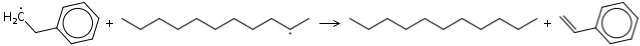

rxn#181(1/1 Disp): [CH2]Cc1ccccc1(16) + C[CH]CCCCCCCCC(14) <=> undecane(3) + C=Cc1ccccc1(32)


In [62]:
path = paths[0]
path_steps = len(path) - 1
for step in range(path_steps):
    step_pair = (path[step], path[step+1])
    h_abs_rxns = []
    disp_rxns = []
    
    print "\n"
    print "**********Step{0}: {1} --> {2}: {3}*************".\
    format(step, step_pair[0], step_pair[1], G[step_pair[0]][step_pair[1]]['total_flux'])
    if step_pair not in graph_edges_dict_simple:
        step_pair = (step_pair[1], step_pair[0])
                
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print "rxn#{0}: ".format(rxn.index) + str(rxn)
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])

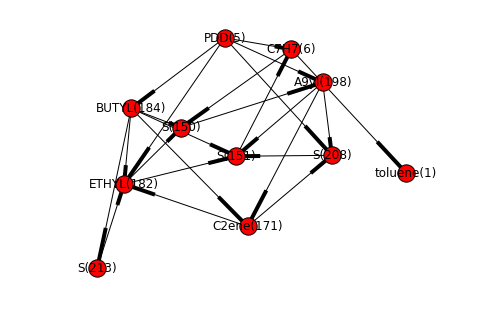

In [139]:
newG = G.subgraph(paths[24908])
nx.draw(newG, with_labels=True)

### s4: find major decomposition paths (without known targets)



**********Step0: C11H24(3) --> C11H23(14): 2.49242834425e-08*************


R_Recombination
rxn#9592: [H](314) + C[CH]CCCCCCCCC(14) <=> undecane(3): -1.692153e-17 


rxn#189(1/40 H_Abs): undecane(3) + CC[CH]CCCCC(7) <=> octane(2) + C[CH]CCCCCCCCC(14)


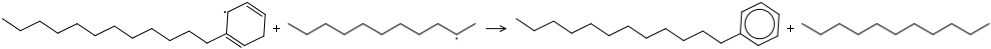

rxn#9646(1/5 Disp): CCCCCCCCCCCCC1C=C[CH]CC=1(321) + C[CH]CCCCCCCCC(14) <=> PDD(5) + undecane(3)


In [68]:
source = "C11H24(3)"
depth = 1
current_node = source
path_top_list = [3,0,0,0,0]
for step in range(depth):
    print "\n"    
    nextNode_flux_list = [(next_node, G[current_node][next_node]['total_flux']) for next_node in G[current_node]]
    sorted_nextNode_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_nextNode_flux_list[path_top_list[step]]
    next_node = tup[0]
    step_flux = tup[1]
    
    print "**********Step{0}: {1} --> {2}: {3}*************".\
    format(step, current_node, next_node, step_flux)
    
    step_pair = (current_node, next_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (next_node, current_node)
    
    h_abs_rxns = []
    disp_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print rxn.family
            print "rxn#{0}: {1}: {2} ".format(rxn.index, str(rxn), graph_edges_dict_simple[step_pair][rxn][timepoint_index])
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])
    
    current_node = next_node

('C11H23(14)', 'C11H24(3)')
**********************************************************************************


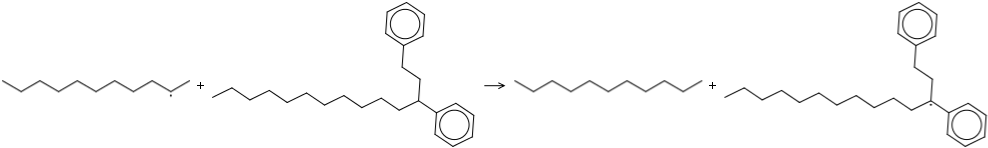

rxn#2613: C[CH]CCCCCCCCC(14) + CCCCCCCCCCCC(CCc1ccccc1)c1ccccc1(302) <=> undecane(3) + CCCCCCCCCCC[C](CCC1C=CC=CC=1)C1C=CC=CC=1(328): -6.064836e-09 
**********************************************************************************


rxn#60: undecane(3) + CCCC[CH]CCCCCC(12) <=> undecane(3) + C[CH]CCCCCCCCC(14): -1.774203e-08 
**********************************************************************************


rxn#48: undecane(3) + CCC[CH]CCCCCCC(11) <=> undecane(3) + C[CH]CCCCCCCCC(14): -1.753597e-08 
**********************************************************************************


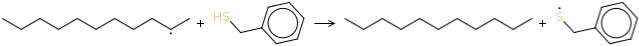

rxn#9705: C[CH]CCCCCCCCC(14) + SCc1ccccc1(374) <=> undecane(3) + [S]Cc1ccccc1(336): 9.248549e-09 
**********************************************************************************


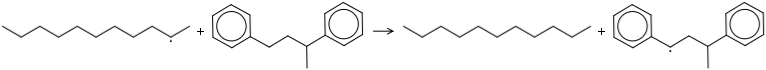

rxn#2593: C[CH]CCCCCCCCC(14) + CC(CCC1C=CC=CC=1)C1C=CC=CC=1(325) <=> undecane(3) + CC(C[CH]C1C=CC=CC=1)C1C=CC=CC=1(323): 7.269931e-09 
**********************************************************************************


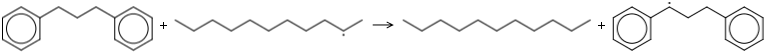

rxn#114: DPP(4) + C[CH]CCCCCCCCC(14) <=> undecane(3) + [CH](CCc1ccccc1)c1ccccc1(17): -1.533431e-08 
**********************************************************************************


rxn#1962: C[CH]CCCCCCCCC(14) + C11ene(180) <=> C=C[CH]CCCCCCCC(255) + undecane(3): -8.120071e-09 
**********************************************************************************


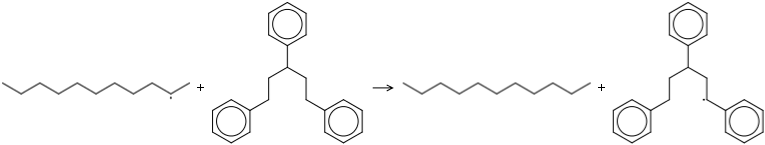

rxn#2597: C[CH]CCCCCCCCC(14) + C1=CC=C(C=C1)CCC(CCC1C=CC=CC=1)C1C=CC=CC=1(326) <=> undecane(3) + [CH](CC(CCC1C=CC=CC=1)C1C=CC=CC=1)C1C=CC=CC=1(324): 5.305155e-09 
**********************************************************************************


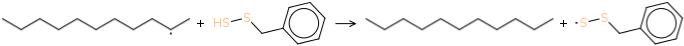

rxn#9707: C[CH]CCCCCCCCC(14) + SSCc1ccccc1(337) <=> undecane(3) + [S]SCc1ccccc1(334): 7.247677e-08 
**********************************************************************************


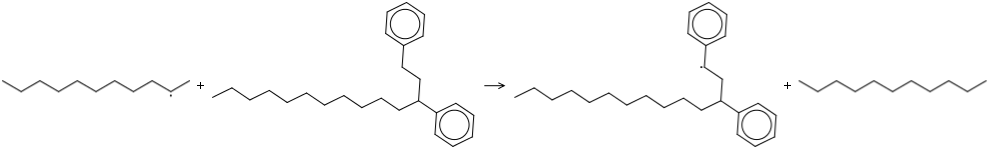

rxn#2595: C[CH]CCCCCCCCC(14) + CCCCCCCCCCCC(CCc1ccccc1)c1ccccc1(302) <=> CCCCCCCCCCCC(C[CH]c1ccccc1)c1ccccc1(296) + undecane(3): 1.126898e-08 
**********************************************************************************


rxn#81: undecane(3) + CCCCC[CH]CCCCC(13) <=> undecane(3) + C[CH]CCCCCCCCC(14): -7.747051e-09 
**********************************************************************************


rxn#37: undecane(3) + CC[CH]CCCCCCCC(10) <=> undecane(3) + C[CH]CCCCCCCCC(14): -1.599966e-08 


In [70]:
print step_pair
for rxn in h_abs_rxns + disp_rxns:
    flux = graph_edges_dict_simple[step_pair][rxn][timepoint_index]
    if abs(flux) > 5e-9:
        print "**********************************************************************************"
        display(rxn) 
        print "rxn#{0}: {1}: {2} ".format(rxn.index, str(rxn), flux) # positive flux means production of pair node1

### s5: find major generation paths (without known sources)



**********Step0: C11H23(10) <-- C18H31(54): 1.934676e-14*************


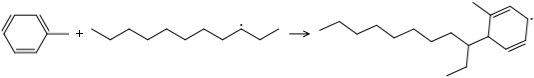

rxn#44: toluene(1) + CC[CH]CCCCCCCC(10) <=> CCCCCCCCC(CC)C1C=CC=C[C]1C(54)


In [52]:
target = "C11H23(10)"
depth = 1
current_node = target
path_top_list = [0, 0]
for step in range(depth):
    print "\n"
    prev_nodes = []
    for node1 in G:
        if current_node in G[node1]:
            prev_nodes.append(node1)
    prevNode_flux_list = [(prev_node, G[prev_node][current_node]['total_flux']) for prev_node in prev_nodes]
    sorted_prevNode_flux_list = sorted(prevNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_prevNode_flux_list[path_top_list[step]]
    prev_node = tup[0]
    step_flux = tup[1]
    
    print "**********Step{0}: {1} <-- {2}: {3}*************".\
    format(step, current_node, prev_node, step_flux)
    
    step_pair = (prev_node, current_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (current_node, prev_node)
    
    h_abs_rxns = []
    disp_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print "rxn#{0}: ".format(rxn.index) + str(rxn)
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])
    
    current_node = prev_node